In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    KFold,
    StratifiedGroupKFold,
    GroupKFold,
    StratifiedKFold,
)

In [87]:
df = pd.read_csv('../Data/merged_cleaned.csv',
                 index_col= [0],
                 parse_dates= [0])



In [88]:
df_feat_1 = df[['Gesamt (Netzlast) [MWh] Berechnete Auflösungen','Deutschland/Luxemburg [€/MWh] Originalauflösungen',
                'hour_sin','dayofweek_sin','month_sin','dayofyear_sin']]

In [89]:
df_load = df_feat_1.iloc[:, [0]]

Train test split

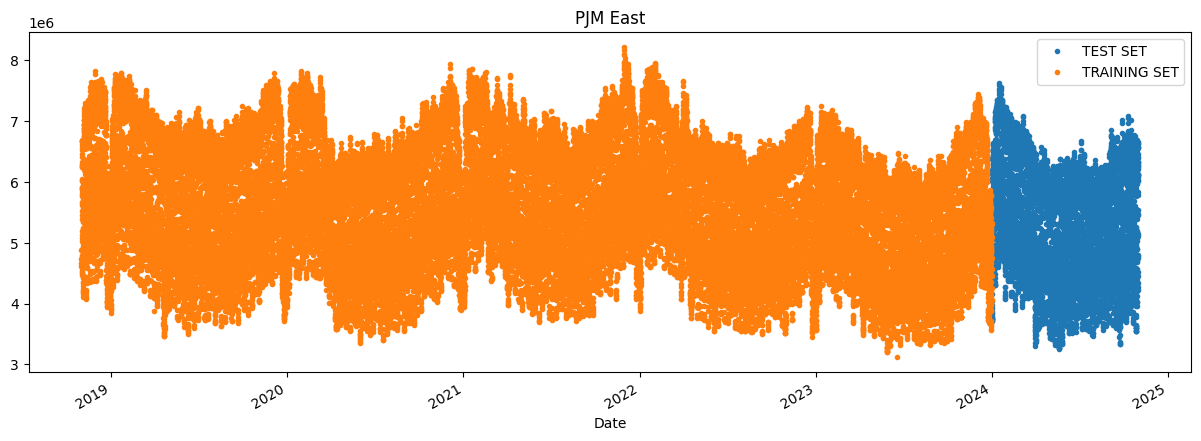

In [90]:
split_date = '01.01.2024'
train = df_load.loc[df_load.index <= split_date].copy()
test = df_load.loc[df_load.index > split_date].copy()

# Plot train and test so you can see where we have split
test \
    .rename(columns={'Gesamt (Netzlast) [MWh] Berechnete Auflösungen': 'TEST SET'}) \
    .join(train.rename(columns={'Gesamt (Netzlast) [MWh] Berechnete Auflösungen': 'TRAINING SET'}), 
          how='outer', lsuffix='_test', rsuffix='_train') \
    .plot(figsize=(15, 5), title='PJM East', style='.')
plt.show()


## Simple Prohphet model

In [91]:
train_prophet = train.reset_index() \
    .rename(columns= {'Date':'ds',
                      'Gesamt (Netzlast) [MWh] Berechnete Auflösungen': 'y'})

In [92]:
%%time
model = Prophet()
model.fit(train_prophet)

13:52:12 - cmdstanpy - INFO - Chain [1] start processing
13:52:25 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 625 ms
Wall time: 14.4 s


In [93]:
test_prophet = test.reset_index() \
    .rename(columns= {'Date':'ds',
                      'Gesamt (Netzlast) [MWh] Berechnete Auflösungen': 'y'})

test_forecast = model.predict(test_prophet)

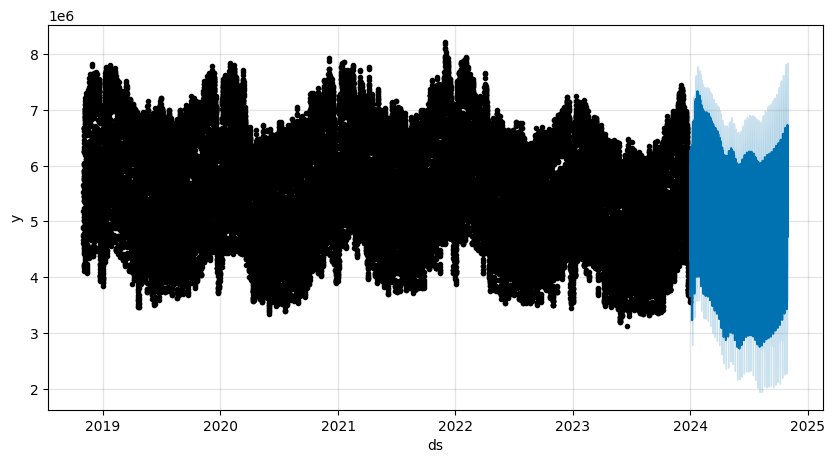

In [94]:
fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(test_forecast, ax=ax)

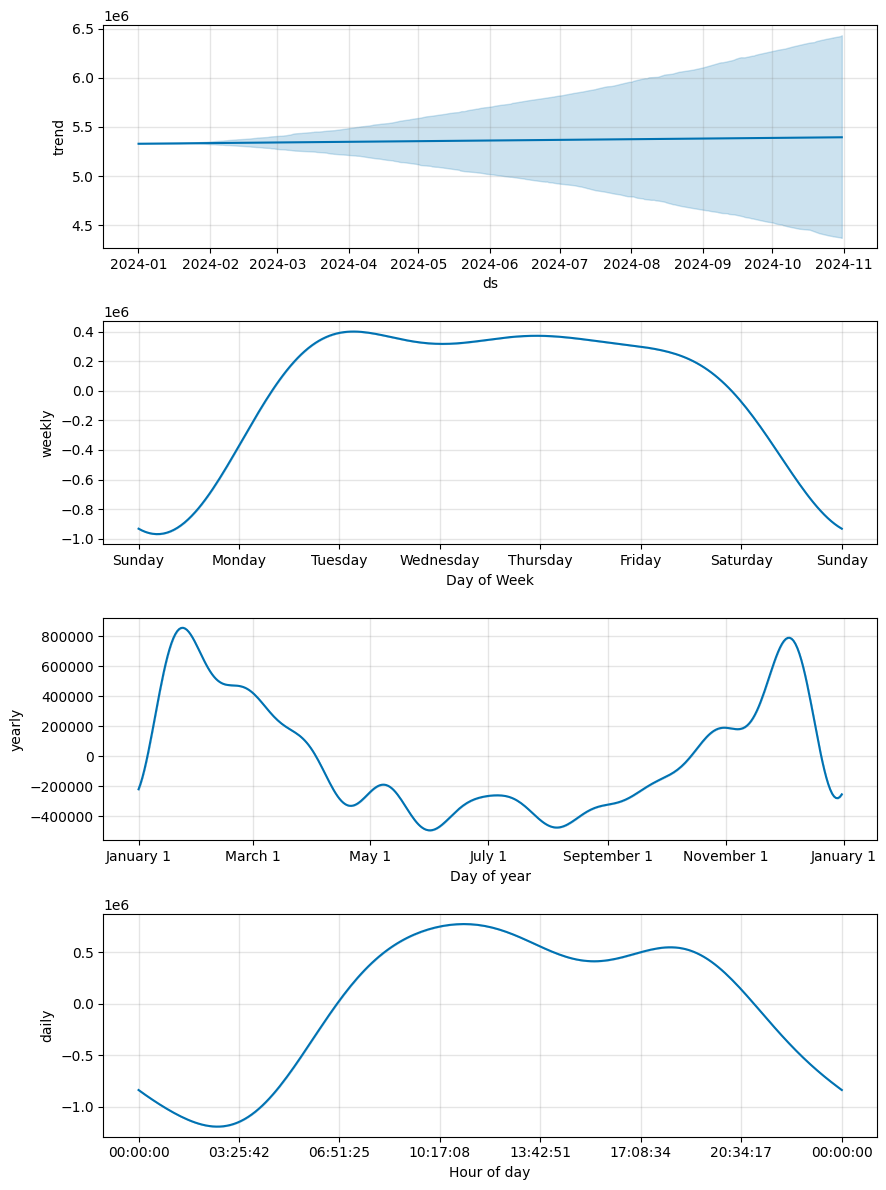

In [95]:
fig = model.plot_components(test_forecast)
plt.show()

In [96]:
test

,Gesamt (Netzlast) [MWh] Berechnete Auflösungen
Date,
2024-01-01 01:00:00,3922125.0
2024-01-01 02:00:00,3823850.0
2024-01-01 03:00:00,3750850.0
2024-01-01 04:00:00,3713475.0
2024-01-01 05:00:00,3743725.0
...,...
2024-10-30 19:00:00,6113950.0
2024-10-30 20:00:00,5836650.0
2024-10-30 21:00:00,5469025.0


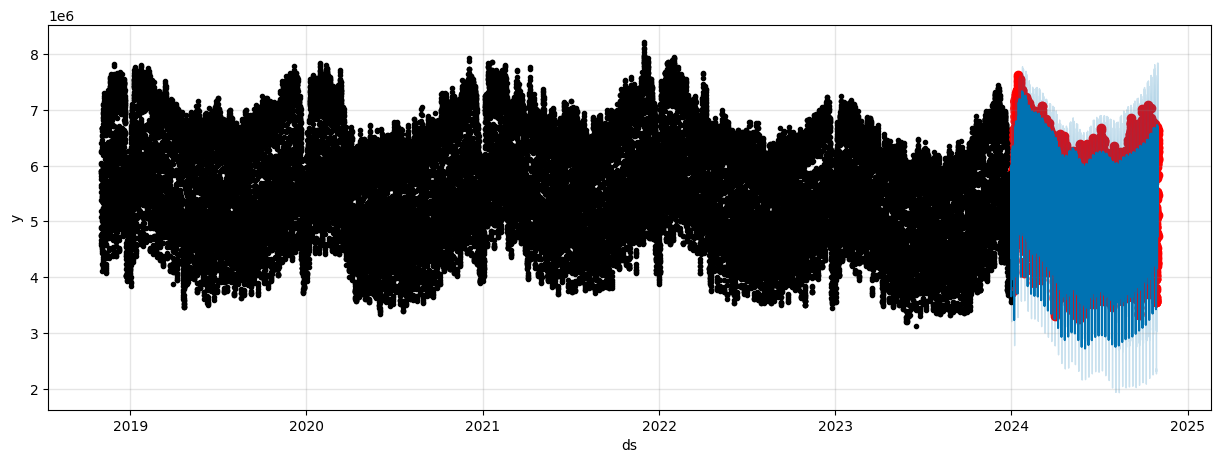

In [97]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test['Gesamt (Netzlast) [MWh] Berechnete Auflösungen'], color='r')
fig = model.plot(test_forecast, ax=ax)

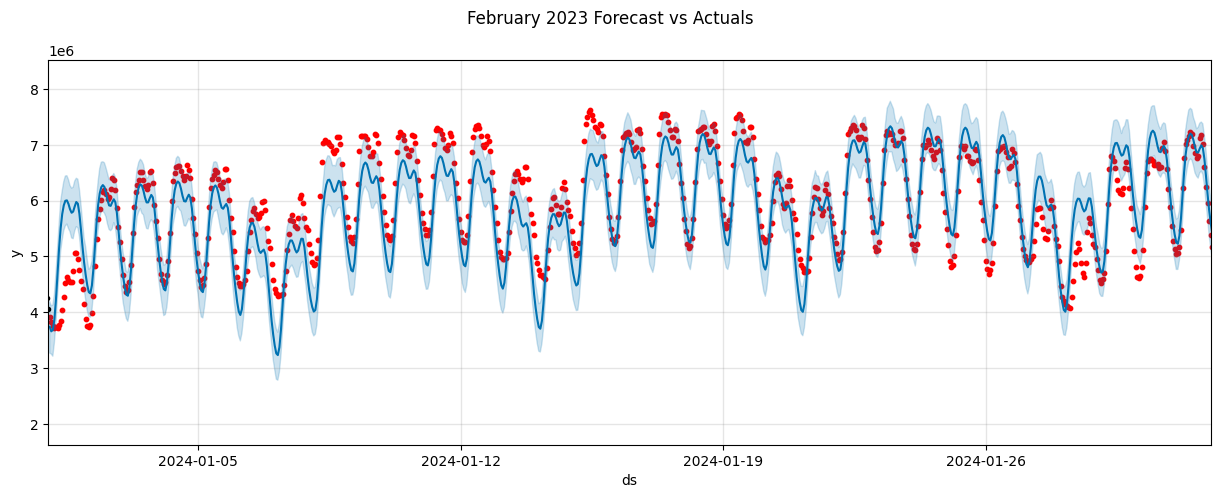

In [100]:
# Filter test data for February 2023
test_february = test.loc['2024-01-01':'2024-02-01']

# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))

# Scatter plot for actuals (February 2023 only)
ax.scatter(test_february.index, test_february['Gesamt (Netzlast) [MWh] Berechnete Auflösungen'], color='r', s=10)

# Plot the forecast (ensure test_forecast contains the relevant forecast for February)
fig = model.plot(test_forecast, ax=ax)

# Set the x-axis limits to February 2023
ax.set_xlim(pd.to_datetime('2024-01-01'), pd.to_datetime('2024-02-01'))

# Title of the plot
plt.suptitle('February 2023 Forecast vs Actuals')

# Show the plot
plt.show()


In [101]:
mean_absolute_percentage_error(y_true = test['Gesamt (Netzlast) [MWh] Berechnete Auflösungen'], y_pred = test_forecast['yhat'])

0.053319610604617214